In [1]:
import numpy as np
import torch 
import torch.nn as nn 
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt 
import helper_utils


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'using device : CUDA')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f'using device : MPS Apple Silicon GPU')
else:
    device = torch.device("cpu")
    print(f'using device : CPU')

using device : MPS Apple Silicon GPU


In [3]:
## Now the time to prepare the data

In [4]:
data_path = "./data"
train_dataset_without_transform = torchvision.datasets.MNIST(
    root= data_path,
    train=True,
    download=True
)

In [5]:
# dataset only accept numerical indices

image_pil, label = train_dataset_without_transform[0]
image_pil

In [6]:
type(image_pil)

PIL.Image.Image

In [7]:
image_pil.size

(28, 28)

In [8]:
label

5

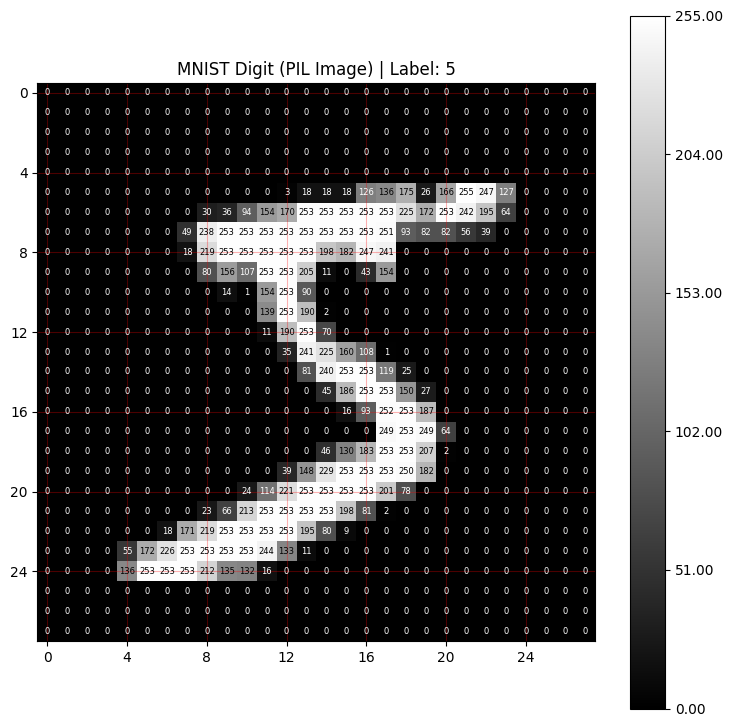

In [9]:
helper_utils.display_image(image_pil,label,"MNIST Digit (PIL Image)", show_values=True)

In [10]:
## Start transforms and make MNIST data, pixel value range from [0,255] -> [0,1]

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,),(0.3081,))
    ]
)

### Apply this transform into your original function (see below comments, which show original one without transform)

train_dataset = torchvision.datasets.MNIST(
    root= data_path,
    train= True, 
    download=True,
    transform= transform
)

image_tensor, label_tensor = train_dataset[0] # ---> (image tensor, label) , image tensor will be in shape (1,28,28)
image_tensor.shape

torch.Size([1, 28, 28])

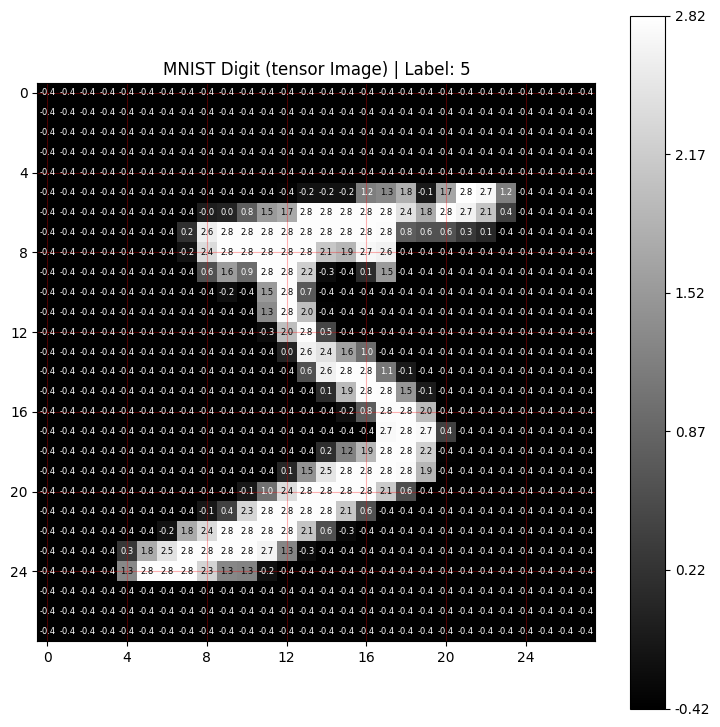

In [11]:
helper_utils.display_image(image_tensor,label_tensor,"MNIST Digit (tensor Image)", show_values=True)

Remember initial code to load tran data set

    train_dataset_without_transform = torchvision.datasets.MNIST(
        root= data_path,
        train=True,
        download=True
    )

In [12]:
## now it is time to set testing data for verifying how traning data perform 
test_dataset = torchvision.datasets.MNIST(
    root= data_path,
    train= False, 
    download=True,
    transform=transform
)

In [13]:
## Now it is time to build data loader, for training size should be small , since we need to calcs gradients 
## for testing it can be large since we just need to verify 

train_loader = DataLoader(
    train_dataset, 
    batch_size= 64,
    shuffle= True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size= 1000,
    shuffle=False
)

In [14]:
## Now we did data cleaning, and dataloader configuration, time to build the model 

## bring up the model class 

class MNISTDNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(784,128),
            nn.ReLU(),
            nn.Linear(128,10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers(x)
        return x 


1. Create the model instance
2. Select correct loss function , since classification -> entropyloss 
3. select optimizer -> Adam  flexible tune the gradient, helps learn more quickly



In [15]:
model = MNISTDNN()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr= 0.01
)

Steps in each epoch:  
1. move model and batch data to training device (cpu or gpu)
2. zero gradient the optimizer 


In [16]:
# testing cells

In [ ]:
## Define the traning epoch
def train_epoch (model, loss_function, optimizer, train_loader, device): 

    # move model to correct device
    model = model.to(device)

    # model to training mode 
    model.train()
    # total epoch's loss tracker 
    epoch_loss = 0.0 
    # periodic tracker 
    running_loss =0.0 
    num_correct_predictions = 0 
    total_predictions =0 
    total_batches = len(train_loader) # -> round(60000/64) 

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # input shape (64,1,28,28) -> indicate that 64 batch, 1 chanel since grey scale, 28x28 pixel, output shape (64)
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        # accum loss 
        loss_value  = loss.item() 
        epoch_loss += loss_value
        running_loss += loss_value
        # calc accuracy for current batch 

        _, predicted_indices = outputs.max(1) 
        #-> output returns (probability, index of the label) , if batch size is 64, then it returns 
        # 1. max probability of the index, (normally ignore)
        # 2. the index itself, we care

        batch_size = targets.size(0)

        total_predictions += batch_size
        # eq() function is to compare predicted_indices with targets, return a list of boolean [true, false, ...]
        # and sum() of it means to like to count how many match, .item() to convert tensor to integer (standard py number)
        num_correct_in_batch = predicted_indices.eq(targets).sum().item()

        num_correct_predictions += num_correct_in_batch

        # progress update 

        # Check if it's time to print a progress update
        if (batch_idx + 1) % 134 == 0 or (batch_idx + 1) == total_batches:
            # Calculate average loss and accuracy for the current interval
            avg_running_loss = running_loss / 134
            accuracy = 100. * num_correct_predictions / total_predictions
            
            # Print the progress update
            print(f'\tStep {batch_idx + 1}/{total_batches} - Loss: {avg_running_loss:.3f} | Acc: {accuracy:.2f}%')
            
            # Reset the trackers for the next reporting interval
            running_loss = 0.0
            num_correct_predictions = 0
            total_predictions = 0
            
    # Calculate the average loss for the entire epoch
    avg_epoch_loss = epoch_loss / total_batches
    # Return the trained model and the average epoch loss
    return model, avg_epoch_loss




outputs tensor: [ [Dog_Score, Cat_Score, Bird_Score] ]

outputs = torch.tensor([
    [0.1, 0.8, 0.1],  # Image 1: Highest score is 0.8 at Index 1 (Cat)
    [0.6, 0.3, 0.1]   # Image 2: Highest score is 0.6 at Index 0 (Dog)
])

Run the code

max_values, predicted_indices = outputs.max(1)

The Underscore (_) catches this:

tensor([0.8, 0.6])  <-- We often throw this away

predicted_indices catches this:

tensor([1, 0])      <-- These are your final predictions: [Cat, Dog]

In [ ]:
# # outputs tensor: [ [Dog_Score, Cat_Score, Bird_Score] ]
# outputs = torch.tensor([
#     [0.1, 0.8, 0.1],  # Image 1: Highest score is 0.8 at Index 1 (Cat)
#     [0.6, 0.3, 0.1]   # Image 2: Highest score is 0.6 at Index 0 (Dog)
# ])

# # Run the code
# #max_values, predicted_indices = outputs.max(1)

# # The Underscore (_) catches this:
# # tensor([0.8, 0.6])  <-- We often throw this away

# # predicted_indices catches this:
# # tensor([1, 0])      <-- These are your final predictions: [Cat, Dog]

In [18]:
def evaluate(model, test_loader, device):
    # Sets the model to evaluation mode.
    model.eval()
    # Initializes a counter for correct predictions.
    num_correct_predictions = 0
    # Initializes a counter for the total number of predictions.
    total_predictions = 0

    # Disables gradient calculation to reduce memory usage and speed up computations.
    with torch.no_grad():
        # Iterates over all batches in the test data loader.
        for inputs, targets in test_loader:
            # Moves the input data and targets to the specified device.
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Performs a forward pass to get the model's output.
            outputs = model(inputs)
            
            # Retrieves the index of the highest value in the output tensor, which represents the predicted class.
            _, predicted_indices = outputs.max(1)
            
            # Gets the size of the current batch.
            batch_size = targets.size(0)
            # Adds the batch size to the total number of predictions.
            total_predictions = total_predictions + batch_size
            
            # Compares the predicted indices with the actual target values.
            correct_predictions = predicted_indices.eq(targets)
            # Sums the correct predictions in the current batch.
            num_correct_in_batch = correct_predictions.sum().item()
            # Adds the correct predictions from the current batch to the total count.
            num_correct_predictions = num_correct_predictions + num_correct_in_batch

    # Calculates the overall accuracy as a percentage.
    accuracy_percentage = (num_correct_predictions / total_predictions) * 100
    # Prints the calculated accuracy to the console.
    print((f'\tAccuracy - {accuracy_percentage:.2f}%'))
    return accuracy_percentage

In [20]:
# Set the total number of training epochs (Feel free to set a different number)
num_epochs = 5

# Initialize lists to store metrics from each epoch for later analysis
train_loss = []
test_acc = []

# Begin the training and evaluation process
for epoch in range(num_epochs):
    print(f'\n[Training] Epoch {epoch+1}:')
    # Call the training function to train the model for one epoch
    trained_model, loss = train_epoch(model, loss_function, optimizer, train_loader, device)
    # Store the average training loss for the epoch
    train_loss.append(loss)
    
    print(f'[Testing] Epoch {epoch+1}:')
    # Call the evaluation function to measure performance on the test set
    accuracy = evaluate(trained_model, test_loader, device)
    # Store the test accuracy for the epoch
    test_acc.append(accuracy)


[Training] Epoch 1:
	Step 134/938 - Loss: 0.172 | Acc: 95.72%
	Step 268/938 - Loss: 0.167 | Acc: 95.63%
	Step 402/938 - Loss: 0.162 | Acc: 95.90%
	Step 536/938 - Loss: 0.165 | Acc: 95.53%
	Step 670/938 - Loss: 0.171 | Acc: 95.58%
	Step 804/938 - Loss: 0.167 | Acc: 95.65%
	Step 938/938 - Loss: 0.202 | Acc: 95.25%
[Testing] Epoch 1:
	Accuracy - 94.32%

[Training] Epoch 2:


KeyboardInterrupt: 